# Analyze the precuneus searchlight cluster

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
import pymc3 as pm
import bambi as bmb
import arviz as az

from tesser import rsa
from tesser import tasks

bids_dir = os.environ['TESSER_BIDS']
res_dir = os.environ['TESSER_RESULTS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'plots')
os.makedirs(fig_dir, exist_ok=True)
beta_dir = os.path.join(res_dir, 'beta', 'smooth4mm')

/Users/morton/anaconda3/envs/tesser2/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/Users/morton/anaconda3/envs/tesser2/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


## Load cluster pattern stats

In [2]:
roi = 'gray'
contrast = 'community_bias'
stat = 'bias'
cluster = 'precl'
dilate = 2

subjects = tasks.get_subj_list()
patterns = []
for subject in subjects:
    mat, events = rsa.load_cluster_patterns(
        beta_dir, subject, roi, contrast, stat, cluster, dilate
    )
    patterns.append(mat)
sim = rsa.beta_sim_stats(events, patterns)
diff = sim['within'] - sim['across']

## Load induction task performance

In [3]:
induct_raw = tasks.load_induct(bids_dir)
induct = tasks.score_induct(induct_raw)
bias_trial = (
    induct.groupby(['subject', 'trial_type'])['correct']
    .mean()
    .unstack('trial_type')
)
bias_trial['diff'] = diff
c = bias_trial['central'].to_numpy()
b1 = bias_trial['boundary1'].to_numpy()
b2 = bias_trial['boundary2'].to_numpy()

## Test relationships between pattern similarity and inference

In [4]:
x = np.vstack([np.ones(c.shape), c, b1, b2]).T
y = diff
pg.linear_regression(x, y)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.015492,0.006657,-2.327281,0.026232,0.31705,0.254964,-0.029035,-0.001949
1,x2,0.021217,0.011353,1.868922,0.070531,0.31705,0.254964,-0.001880,0.044315
2,x3,0.016496,0.007846,2.102567,0.043214,0.31705,0.254964,0.000534,0.032458
3,x4,-0.008583,0.006563,-1.307834,0.199967,0.31705,0.254964,-0.021935,0.004769


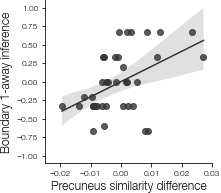

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))
x = diff
y = (b1 - .5) * 2
sns.regplot(x=x, y=y, ax=ax, color=(.2, .2, .2))
ax.set(
    xlim=(-0.025, 0.03),
    ylim=(-1.1, 1.1),
    xlabel='Precuneus similarity difference',
    ylabel='Boundary 1-away inference',
);
fig.savefig(os.path.join(fig_dir, 'precl_b1.pdf'))

In [6]:
model = bmb.Model('diff ~ central + boundary1 + boundary2', bias_trial)
model.build()

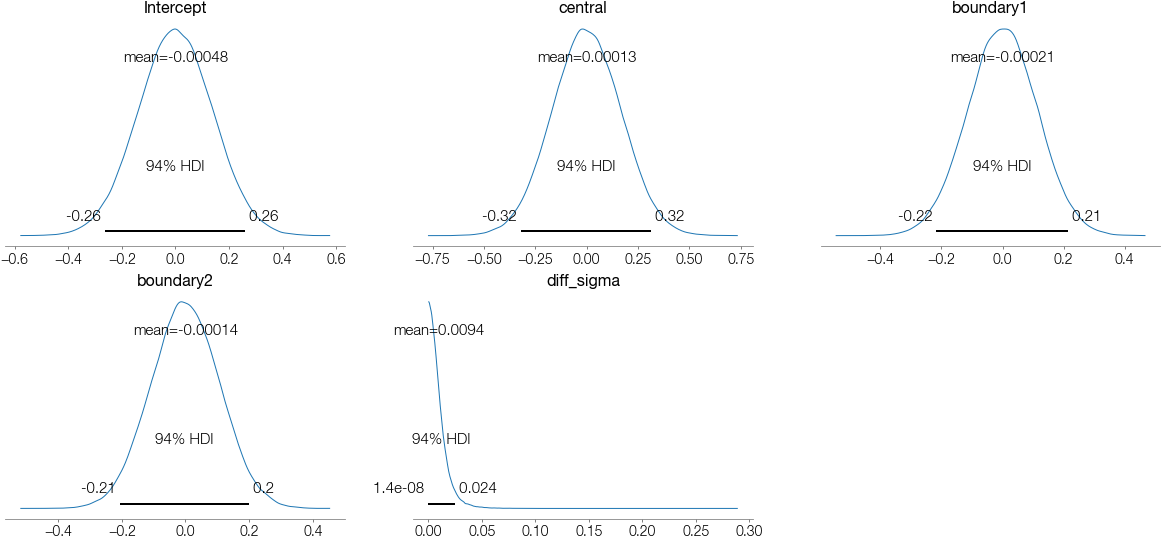

In [7]:
model.plot_priors(draws=100000);

In [8]:
results = model.fit(draws=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [diff_sigma, boundary2, boundary1, central, Intercept]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


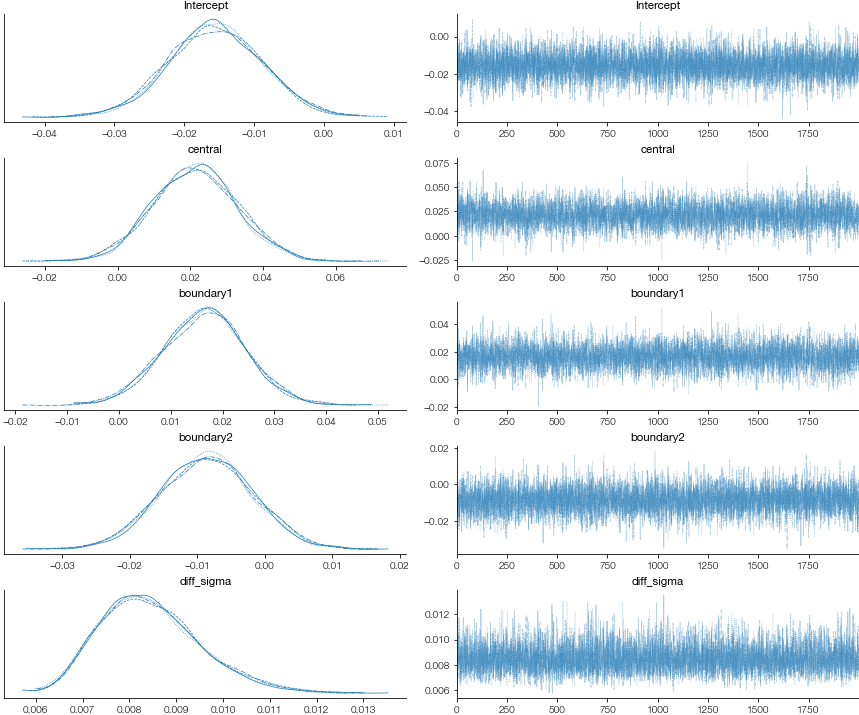

In [9]:
with mpl.rc_context({'figure.constrained_layout.use': True}):
    az.plot_trace(results);

In [10]:
pd.options.display.float_format = "{:,.4f}".format
summary = az.summary(results, hdi_prob=0.95)
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.0160,0.0070,-0.0290,-0.0030,0.0000,0.0000,"9,509.0000","6,405.0000",1.0000
central,0.0210,0.0120,-0.0010,0.0440,0.0000,0.0000,"5,962.0000","5,905.0000",1.0000
boundary1,0.0160,0.0080,0.0010,0.0330,0.0000,0.0000,"6,250.0000","6,118.0000",1.0000
boundary2,-0.0090,0.0070,-0.0210,0.0050,0.0000,0.0000,"7,796.0000","5,975.0000",1.0000
diff_sigma,0.0080,0.0010,0.0070,0.0110,0.0000,0.0000,"6,780.0000","5,779.0000",1.0000


In [14]:
summary.min()

mean           -0.0160
sd              0.0010
hdi_2.5%       -0.0290
hdi_97.5%      -0.0030
mcse_mean       0.0000
mcse_sd         0.0000
ess_bulk    5,962.0000
ess_tail    5,779.0000
r_hat           1.0000
dtype: float64

In [11]:
# posterior regression samples
x = bias_trial['boundary1'].to_numpy()
y = bias_trial['diff'].to_numpy()

draws = results.posterior.stack(sample=('draw', 'chain'))
n_s = draws.dims['sample']
n_x = 100
x_range = np.linspace(np.min(x), np.max(x), n_x)
ys = np.zeros((n_s, n_x))
for i in range(n_s):
    draw = draws.isel(sample=i)
    y_hat = (
        draw['Intercept'].values
        + draw['central'].values * bias_trial['central'].mean()
        + draw['boundary2'].values * bias_trial['boundary2'].mean()
        + draw['boundary1'].values * x_range
    )
    ys[i, :] = y_hat

ci = np.zeros((2, n_x))
for i in range(n_x):
    ci[:, i] = az.hdi(ys[:, i], hdi_prob=0.95)

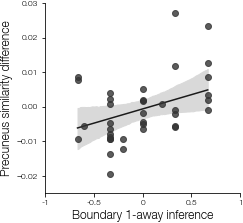

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax.fill_between(x_range, ci[0], ci[1], color=(0.85, 0.85, 0.85))

# mean posterior regression line
y_pred = (
    results.posterior.Intercept.values.mean()
    + results.posterior['central'].values.mean() * bias_trial['central'].mean()
    + results.posterior['boundary2'].values.mean() * bias_trial['boundary2'].mean()
    + results.posterior['boundary1'].values.mean() * x_range
)
ax.plot(x_range, y_pred, '-', color=(.1, .1, .1), linewidth=1.5)

ax.plot(x, y, 'o', color=(.2, .2, .2), alpha=0.8, clip_on=False)

ax.set(
    ylim=(-0.025, 0.03),
    xlim=(0, 1),
    xticks=(0, .25, .5, .75, 1),
    xticklabels=(-1, -0.5, 0, 0.5, 1),
    ylabel='Precuneus similarity difference',
    xlabel='Boundary 1-away inference',
);
fig.savefig(os.path.join(fig_dir, 'precl_b1_bayes.pdf'))

In [13]:
%load_ext watermark
%watermark -i -m -v -iv

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.28.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

pingouin  : 0.5.0
tesser    : 1.0.0
pymc3     : 3.11.4
pandas    : 1.3.3
arviz     : 0.11.4
numpy     : 1.21.2
bambi     : 0.7.1
matplotlib: 3.4.3
seaborn   : 0.11.2

